作业五是根据Text8的语料库训练一个语言模型word2vec，得到语料库中每个词的嵌入式表达（向量），从而可以量化不同词之间的语义距离。word2vec本质上是种非监督学习，输入训练语料，本质上利用词的上下文信息作为“监督”，上下文相似的两个词在语义上更相似，不断输入语料，使得上下文相似的两个词的向量表达更加“相似”。

Mikolov提出的word2vec包括skip-gram和CBOW两种模型，前者是根据给定词预测其周围的词，后者是根据周围的词预测中间的词。Mikolov最大的贡献是采用negative sampling的方法极大提升神经网络模型的计算效率。官方的作业ipynb给出了skip-gram的实现，要求我们给出CBOW实现。

Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
          'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

## 注释

下载完Text8.zip解压缩，读出数据并分词，大概1700w个重复词。设置字典大小vocabulary_size为5w，即只有5w个unique词，统计词频构建字典：

- ``collections.Counter(words).most_common(vocabulary_size-1)`` 这个函数好强大，直接返回给定words列表的出现频数Top-K统计结果（词，词频），因为考虑要未知词UNKnown word（UNK），留了一个位置，K设置为字典大小减一。
- 根据统计词频count，构建字典dictionary，word作为key，word在count中的次序index作为value
- 遍历一遍词袋words，对词袋中的每个词，依次记录其在字典的索引index，得到data
- 最后的zip操作（构建tuple）是互换原来字典的key和value，重新构建一个字典reverse_dictionary，key是index，value是对应的词，方便根据索引找到词

In [3]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]] # count的第一项
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
        # key为word，value表示word在count中的次序index
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary: 
            index = dictionary[word] 
        else:
            index = 0  # dictionary['UNK']
        unk_count = unk_count + 1
        data.append(index) 
        # data记录words每个词在字典中的index；不在字典的视为UNK，index用0
    count[0][1] = unk_count # 用最新统计的unk词频取代原来('unk', -1)的-1
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    # 互换原来字典的key和value，重新构建字典，方便根据index找到word
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 17005207], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [32]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    """
    batch_size, 每次训练数据的batch大小，是num_skips的整数倍，这里用8
    num_skips, 目标词左和右的总词数，最大设为2倍skip_window
    skip_window, 目标词左（右）的词数，计算整个窗口span=2*skip_window+1
    """
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window 
    # 初始化
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span): # 初始化一个span大小的buffer
        buffer.append(data[data_index]) 
        data_index = (data_index + 1) % len(data) # 处理词序列边界，保证data_index在data范围
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ] # skip_window刚好是一个span中的中间词下标
        for j in range(num_skips): # 遍历目标词的上下文，作为labels
            while target in targets_to_avoid:
                target = random.randint(0, span - 1) # 选上下文词：随机挑选span中除了target的一个词
            targets_to_avoid.append(target) # 放入已选中列表，避免重复选
            # batch中的词和labels一一对应，相同的target对应多个上下文词label
            batch[i * num_skips + j] = buffer[skip_window] 
            labels[i * num_skips + j, 0] = buffer[target] 
        # 更新buffer，滑动窗口往后移动一个词，bufer是deque类型，追加一个词会弹出前面一个词
        buffer.append(data[data_index]) 
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]]) # 根据data索引di返回对应的词

# 测试不同的(num_skips, skip_window)，产生的batch和labels
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window) 
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'originated', 'a', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'originated', 'a', 'term', 'term', 'of', 'as', 'originated']


## 注释
skip-grams模型是给定中心词target预测其上下文词。在batch训练数据中，skip_window=1，则取target词的左右各1个词作为输出label，一个target对应多个label，因此看到batch出现2次"originated"，对应label分别为它的上下文"anarchism"和"as"，同理"as", "a", "term"亦如此。

skip_window=2时，取target词左右各2个词作为输出label，"as"对应前面2个词"anarchism"、"originated"和后面2个词"a"、"term"，因此batch出现4个相同的as，对应4个不同的label。

因此word2vec不用人工标注数据，依赖上下文数据，某次样本的输入同时也作为前后两次样本的输出，间接实现了监督学习。

Train a skip-gram model.

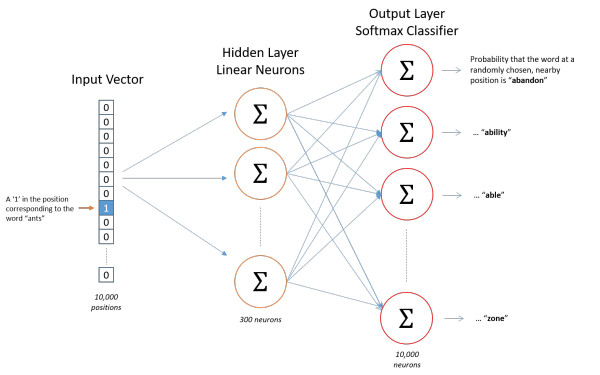

In [18]:
from IPython.display import display, Image

display(Image("neural-network.jpg"))

In [7]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)) # embeddings：词库大小*向量维度
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size))) # softmax的weights：词库大小*向量维度
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size])) # softmax的biases：词库大小 
  
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset) # 按照train_dataset样本的ids顺序返回embeddings中的第ids行
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

## tf.nn.embedding_lookup

```
tf.nn.embedding_lookup(
    params,
    ids,
    partition_strategy='mod',
    name=None,
    validate_indices=True,
    max_norm=None
)
```
- 并行处理，按照ids顺序返回params的ids对应的行
- partition_strategy指定划分方法，mod是对ids取模（``p = id % len(params)``)得到一系列partition，还有种是div

## tf.nn.sampled_softmax_loss

```
tf.nn.sampled_softmax_loss(
    weights,
    biases,
    labels,
    inputs,
    num_sampled,
    num_classes,
    num_true=1,
    sampled_values=None,
    remove_accidental_hits=True,
    partition_strategy='mod',
    name='sampled_softmax_loss'
)
```
- 计算采样softmax训练损失，用于多类别的计算

In [8]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
          batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
            # note that this is expensive (~20% slowdown if computed every 500 steps)
            if step % 10000 == 0:
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = reverse_dictionary[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = reverse_dictionary[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.061249
Nearest to new: impersonal, temptation, reorganisation, cessation, naples, piety, truffaut, recited,
Nearest to its: humayun, errol, caviar, tetrachloride, locust, hanover, appellations, adopts,
Nearest to so: wrong, ionized, translocation, warne, puckett, moth, quizzes, arcade,
Nearest to some: hoyt, attempted, retrofitted, natives, suffixed, deuterostomes, nitrox, albeit,
Nearest to s: colourless, oppressors, ethane, frontman, mile, denatured, publications, coldcut,
Nearest to but: reassembled, rockall, disallow, wilford, tolvaj, androgens, midwifery, lillee,
Nearest to at: prefixes, hypatia, gerhardt, cumbric, baronet, ilo, chicago, pronounces,
Nearest to than: bindusara, nsc, centronics, mellor, fred, wasps, piaget, contracting,
Nearest to of: tripping, security, gloves, eckert, belgium, morgan, dn, gobind,
Nearest to system: hook, ignaz, lucifer, termed, saginaw, yeshiva, notoc, encrypting,
Nearest to if: nepal, serena, carotenoids, max

Average loss at step 52000: 3.437235
Average loss at step 54000: 3.425446
Average loss at step 56000: 3.436136
Average loss at step 58000: 3.395792
Average loss at step 60000: 3.394495
Nearest to new: ah, outta, isaias, molyneux, columbians, ruthenia, louder, spheroidal,
Nearest to its: their, his, the, her, whose, bengal, sizes, safeguard,
Nearest to so: if, less, twisted, dispensationalism, too, wrong, anything, argue,
Nearest to some: many, several, these, any, various, all, most, sandro,
Nearest to s: whose, rabbits, ferrell, smalley, coldcut, isbn, enlistment, caryophyllales,
Nearest to but: however, and, although, though, which, than, when, since,
Nearest to at: elvira, in, nadezhda, on, during, under, faust, fermenting,
Nearest to than: or, much, and, but, purged, nonaligned, witbrock, transporter,
Nearest to of: in, final, for, tripping, grieg, like, psychiatric, same,
Nearest to system: systems, ignaz, noon, command, quiz, institutions, program, launch,
Nearest to if: when, th

In [9]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

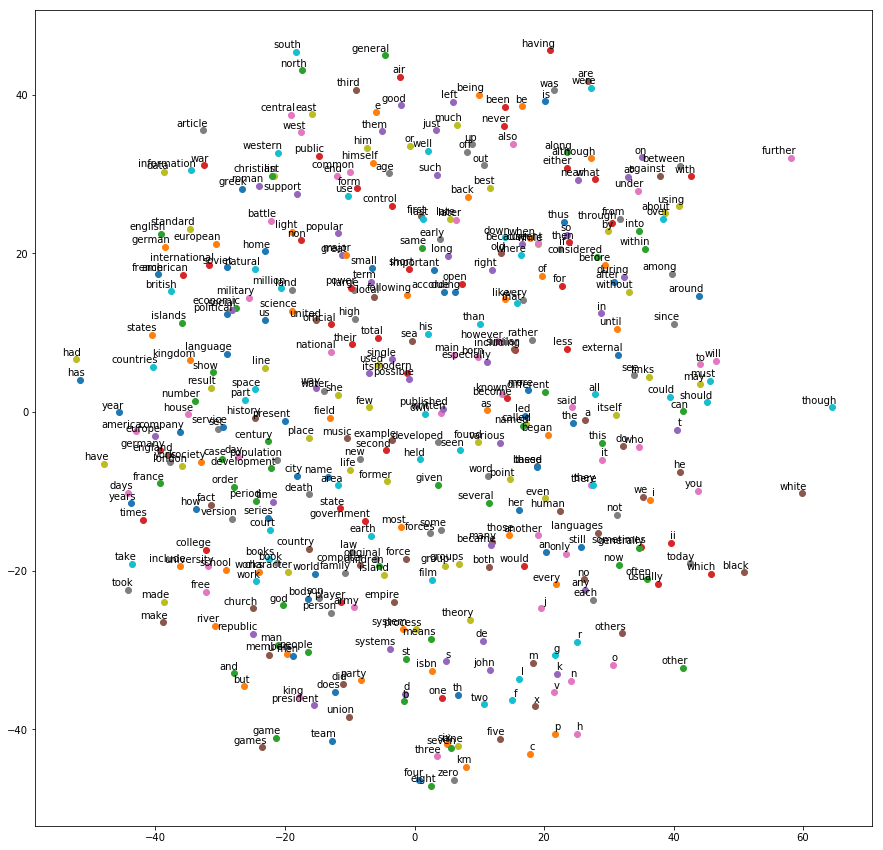

In [10]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

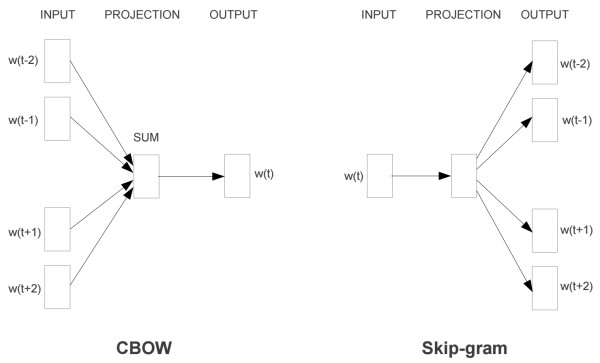

In [11]:
display(Image("word2vec.jpg"))

In [65]:
"""
    For CBOW, given contextual words to predict central target word,
    so use bag_window instead of num_skips & skip_window
"""
data_index = 0

def generate_batch(batch_size, bag_window):
    """
    batch_size: 同skip-grams
    bag_window: 输入待预测中心词的上（下）文词个数
    """
    global data_index
    
    # === modified ===
    span = 2 * bag_window + 1 # [ bag_window target bag_window ]
    batch = np.ndarray(shape=(batch_size, span - 1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    # ================
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size):
        buffer_list = list(buffer)
        labels[i, 0] = buffer_list[bag_window] # buffer的中间词下标是bag_window，作为要预测的label
        batch[i] = np.append(buffer_list[:bag_window], buffer_list[bag_window+1:])
        # 更新buffer，往下平移一个单词
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data_index:', data[:8])
print('data:', [reverse_dictionary[di] for di in data[:8]])

for bag_window in [1, 2]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, bag_window=bag_window)
    print('\nwith bag_window = %d:' % (bag_window))
    print('    batch:', [[reverse_dictionary[w] for w in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data_index: [5239, 3084, 12, 6, 195, 2, 3137, 46]
data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with bag_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against']]
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with bag_window = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first'], ['term', 'of', 'first', 'used'], ['of', 'abuse', 'used', 'against'], ['abuse', 'first', 'against', 'early'], ['first', 'used', 'early', 'working']]
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [69]:
"""
    CBOW Model
"""
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
bag_window = 2 # 左右窗大小
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, bag_window * 2]) # 在skip-grams基础上修改训练集输入
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)) # embeddings：词库大小*向量维度
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size))) # softmax的weights：词库大小*向量维度
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size])) # softmax的biases：词库大小 
  
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset) # 按照train_dataset样本的ids顺序返回embeddings中的第ids行
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=tf.reduce_sum(embed, 1), 
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))
    # 在skip-grams基础上修改inpus=tf.reduce_sum(embed, 1)

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

### 注释：

在skip-grams基础上，主要修改的地方有以下几个：
- ``generate_batch函数``，构造batch和label跟skip-grams相反，用bag_window代替num_skip和skip_window
- ``tf.Graph()``
    - train_dataset中，每个样本有2*bag_window维
    - 损失函数的参数修改为``inpus=tf.reduce_sum(embed, 1)``，reduce_sum沿着1维度对tensor求和

In [70]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
          batch_size, bag_window) # 修改参数为bag_windwow
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
            # note that this is expensive (~20% slowdown if computed every 500 steps)
            if step % 10000 == 0:
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = reverse_dictionary[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = reverse_dictionary[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.123606
Nearest to known: macroeconomics, jeju, elamites, suffolk, smooth, amram, slugger, destructor,
Nearest to no: sothoth, soter, myriad, imprinted, perform, benchmarking, timeframe, cyclopaedia,
Nearest to an: macedonians, intruders, marys, experimented, marge, probus, dachshund, precedes,
Nearest to one: neptune, characterizations, canals, disquieting, ledge, avert, reservations, chem,
Nearest to three: unilaterally, howlin, abc, rental, permian, iconoclastic, collectively, bless,
Nearest to into: unsurprisingly, americana, glycine, cohabitation, easterly, protective, natives, messengers,
Nearest to are: ceremonially, aylwin, splitter, thrown, ahern, honeybee, azov, megan,
Nearest to they: peoples, crioulo, alfaro, bathroom, scavenge, firenze, conducting, desi,
Nearest to s: vinland, adys, descendant, timbuktu, canyons, marsh, bookmakers, invincible,
Nearest to UNK: cnn, fictions, cinco, taking, erase, presto, peng, egon,
Nearest to eight: orp

Average loss at step 52000: 3.096429
Average loss at step 54000: 3.096638
Average loss at step 56000: 2.915055
Average loss at step 58000: 3.027401
Average loss at step 60000: 3.054121
Nearest to known: referred, seen, regarded, described, used, considered, accepted, defined,
Nearest to no: another, any, a, diminished, little, welcomes, opting, mushrooms,
Nearest to an: another, stubbornly, the, leeward, borer, damian, hens, a,
Nearest to one: two, breathtaking, vagus, erc, fy, programmability, gneisenau, cryptanalysis,
Nearest to three: five, four, seven, six, eight, two, zero, nine,
Nearest to into: through, within, from, around, across, under, beyond, slipper,
Nearest to are: were, is, include, was, have, including, remain, contain,
Nearest to they: we, you, he, she, there, these, gems, pearl,
Nearest to s: his, her, whose, their, perdition, bobo, our, beecher,
Nearest to UNK: tehran, puritanical, darrell, auditor, gina, forbids, acetylene, dei,
Nearest to eight: nine, seven, five, 

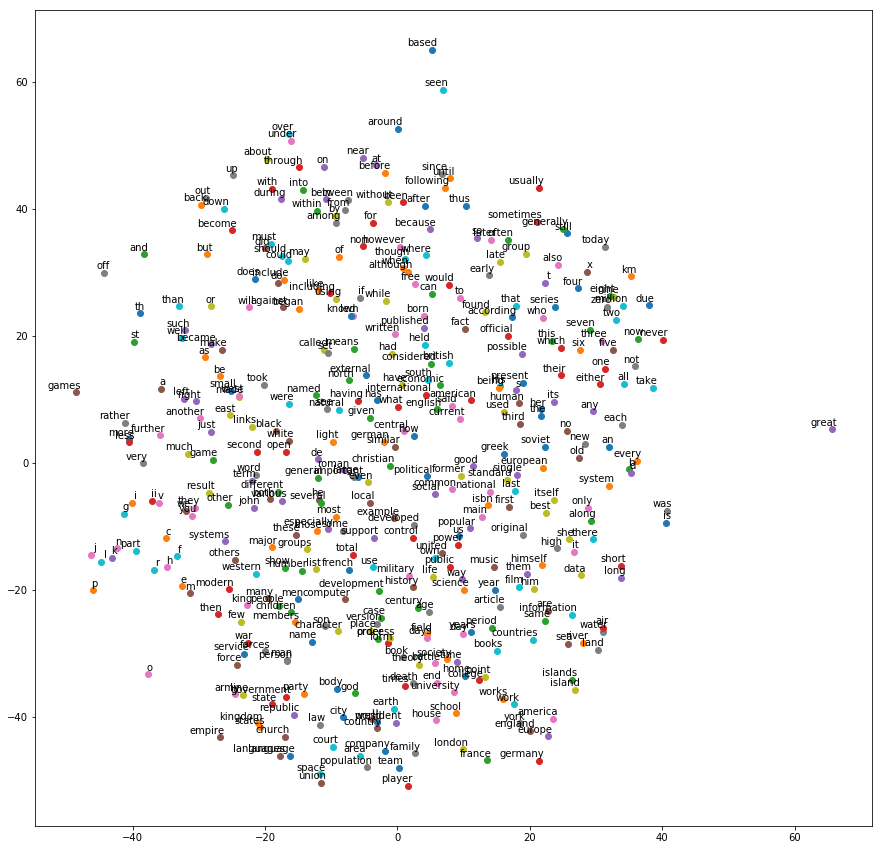

In [71]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)